# 1-D to 3-D Exodus example

In [1]:
# Imports for exodus
import sys
sys.path.append('/Users/adgrube/Desktop/Code/seacas/lib')
import exodus

# Standard imports
import numpy as np
from scipy.linalg import svd
from scipy.sparse import eye, csc_matrix
from scipy.sparse.linalg import spsolve
from scipy.io import mmread, loadmat
import matplotlib.pyplot as plt

# For faster top-k svd algo
from sklearn.utils.extmath import randomized_svd

# Import for utils
sys.path.append("..")
# import utils as u
import ROM_utils as ru
import OpInf_utils as ou

# Creating exodus file
fromFileName = "bracket_velIC_100.e"
toFileName   = "bracket_velIC_100_written.e"

massName  = 'mass.mm'
stiffName = 'stiff.mm'

ROMvariables = ['disp_OpRom_x', 'disp_OpRom_y', 'disp_OpRom_z',
                'disp_NC-H-OpRom_x', 'disp_NC-H-OpRom_y', 'disp_NC-H-OpRom_z',
                'disp_C-H-OpRom_x', 'disp_C-H-OpRom_y', 'disp_C-H-OpRom_z',
                'disp_IntRom_x', 'disp_IntRom_y', 'disp_IntRom_z']

# # Use this the first time the file is created
# exo_copy = exodus.copyTransfer(fromFileName, toFileName,
#                                array_type='numpy',
#                                additionalNodalVariables=ROMvariables)

#Use this after file is created
exo_copy = exodus.exodus(f'{toFileName}', array_type='numpy')

# derp = mmread('bracket/xfinal_distributed.mm')

# N = exo_copy.num_nodes()
# disp_xRecInt  = derp[::3][:N]
# disp_yRecInt  = derp[1::3][:N]
# disp_zRecInt  = derp[2::3][:N]
# i=0
# exo_copy.put_node_variable_values("disp_IntRom_x", i+1, disp_xRecInt[:,i])
# exo_copy.put_node_variable_values("disp_IntRom_y", i+1, disp_yRecInt[:,i])
# exo_copy.put_node_variable_values("disp_IntRom_z", i+1, disp_zRecInt[:,i])


You are using exodus.py v 1.20.17 (seacas-py3), a python wrapper of some of the exodus library.

Copyright (c) 2013-2022 National Technology &
Engineering Solutions of Sandia, LLC (NTESS).  Under the terms of
Contract DE-NA0003525 with NTESS, the U.S. Government retains certain
rights in this software.

Opening exodus file: bracket_velIC_100_written.e


### Function which grabs snapshots from Irina's data and assembles FOM quantities

In [2]:
# Function which grabs everything from the exodus file
# The snapshots are kind of weird -- energy drops after first iteration

def assemble_FOM(exo_file):
    # Import mass and stiffness matrices
    N     = exo_file.num_nodes()
    Nt    = exo_file.num_times()
    mass  = mmread(massName)
    stiff = mmread(stiffName)

    # stiff = 0.5 * (stiff+stiff.T)
    # mass  = 0.5 * (mass+mass.T)
    M = mass.todense()
    K = stiff.todense()


    # Build L matrix
    zz    = np.zeros((3*N, 3*N))
    ii    = np.eye(3*N)
    J     = np.block([[zz, ii], [-ii, zz]])

    # BCset = [0,0,0,0,0,0]
    # BCdofs = []
    # for i in range(6):
    #     BCset[i] = exo_file.get_node_set_nodes(i+1)
    # for i in range(2):
    #     xdofs = (BCset[i]-1)*3 + 0
    #     BCdofs.append(xdofs)
    # for i in range(2,4):
    #     ydofs = (BCset[i]-1)*3 + 1
    #     BCdofs.append(ydofs)
    # for i in range(4,6):
    #     zdofs = (BCset[i]-1)*3 + 2
    #     BCdofs.append(zdofs)

    # BCdofs = np.concatenate(BCdofs, axis=0)

    # ii[BCdofs] = np.zeros(3*N)
    # J     = np.block([[zz, ii], [-ii, zz]])

    # for grad H
    massInv = spsolve(mass.tocsc(), eye(3*N).tocsc())
    A       = np.block([[stiff.todense(), zz], [zz, massInv.todense()]])

    # Solution arrays ordered by node_id
    sol_x   = np.zeros((N, Nt))
    sol_y   = np.zeros((N, Nt))
    sol_z   = np.zeros((N, Nt))

    # for position
    for t in range(Nt):
        sol_x[:,t] = exo_file.get_node_variable_values('disp_x', t+1)
        sol_y[:,t] = exo_file.get_node_variable_values('disp_y', t+1)
        sol_z[:,t] = exo_file.get_node_variable_values('disp_z', t+1)

    # Full position array (interleaved like M, K matrices)
    q_arr       = np.zeros((3*N, Nt))
    q_arr[0::3] = sol_x
    q_arr[1::3] = sol_y
    q_arr[2::3] = sol_z

    # for derivative of position
    for t in range(Nt):
        sol_x[:,t] = exo_file.get_node_variable_values('solution_dot_x', t+1)
        sol_y[:,t] = exo_file.get_node_variable_values('solution_dot_y', t+1)
        sol_z[:,t] = exo_file.get_node_variable_values('solution_dot_z', t+1)

    # Full qDot array
    qDot_arr       = np.zeros((3*N, Nt))
    qDot_arr[0::3] = sol_x
    qDot_arr[1::3] = sol_y
    qDot_arr[2::3] = sol_z

    # Full momentum array (interleaved)
    p_arr = mass @ qDot_arr

    # for derivative of momentum
    for t in range(Nt):
        sol_x[:,t] = exo_file.get_node_variable_values('solution_dotdot_x', t+1)
        sol_y[:,t] = exo_file.get_node_variable_values('solution_dotdot_y', t+1)
        sol_z[:,t] = exo_file.get_node_variable_values('solution_dotdot_z', t+1)

    # Full pDot array
    pDot_arr       = np.zeros((3*N, Nt))
    pDot_arr[0::3] = sol_x
    pDot_arr[1::3] = sol_y
    pDot_arr[2::3] = sol_z
    pDot_arr       = mass @ pDot_arr

    # Build state, state derivative, and gradH
    x_arr     = np.concatenate((q_arr, p_arr), axis=0)
    xDot_arr  = np.concatenate((qDot_arr, pDot_arr), axis=0)
    gradH_arr = csc_matrix(A) @ x_arr

    return (x_arr, xDot_arr, gradH_arr), J, A


# Compute Hamiltonian
def Hamil(data, A):
    result = np.zeros(data.shape[1])
    for i in range(len(result)):
        result[i] = data[:,i].T @ A @ data[:,i]
    return 0.5 * result

In [3]:
# Get data from exodus file (201 snaps)
data, J, A     = assemble_FOM(exo_copy)
Asp            = csc_matrix(A)
Jsp            = csc_matrix(J)

# # Doing the integration (takes about 2:40)
# tTrain = np.linspace(0, 0.02, 201)
# Xt, Xdt, gHt = ru.integrate_Linear_HFOM(tTrain, data[0][:,0], Jsp, Asp)

#Saving the data
# dicto = {'x': Xt, 'xDot': Xdt, 'gradH': gHt}
# from scipy.io import savemat
# savemat('exo_snap201.mat', dicto)

# # Ignore exodus file and get data from Hamiltonian system
# mat            = loadmat('clamped/exo_snaps.mat')
# xData          = mat['x']
# xDotData       = mat['xDot']
# gradHData      = mat['gradH']

# xData, xDotData, gradHData = Xt, Xdt, gHt
xData, xDotData, gradHData = data
xData.shape


(15828, 201)

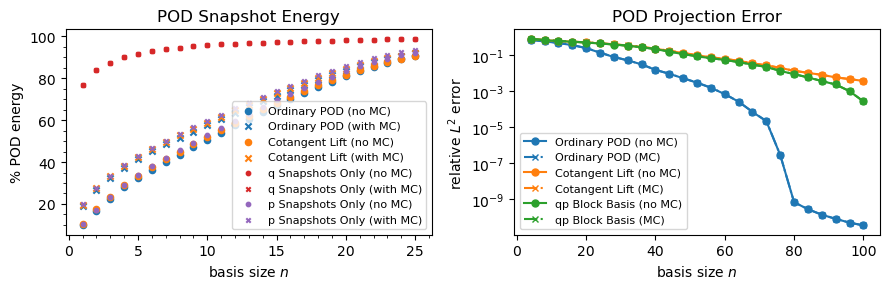

In [4]:
Xt, Xdt, gHt = data

# Xt = data[0][:,::2]
# Xdt = data[1][:,::2]
# gHt = data[2][:,::2]

POD   = ru.Linear_Hamiltonian_ROM(Xt)
POD.set_reduced_basis('POD', rmax=100, randomized=True)
POD.compute_basis_energies()
PODmc = ru.Linear_Hamiltonian_ROM(Xt)
PODmc.set_reduced_basis('POD', centered=True, rmax=100, randomized=True)
PODmc.compute_basis_energies()
CL    = ru.Linear_Hamiltonian_ROM(Xt)
CL.set_reduced_basis('cotangent_lift', rmax=100, randomized=True)
CL.compute_basis_energies()
CLmc  = ru.Linear_Hamiltonian_ROM(Xt)
CLmc.set_reduced_basis('cotangent_lift', centered=True, rmax=100, randomized=True)
CLmc.compute_basis_energies()
QP    = ru.Linear_Hamiltonian_ROM(Xt)
QP.set_reduced_basis('block_qp', rmax=100, randomized=True)
QP.compute_basis_energies()
QPmc  = ru.Linear_Hamiltonian_ROM(Xt)
QPmc.set_reduced_basis('block_qp', centered=True, rmax=100, randomized=True)
QPmc.compute_basis_energies()
QQ    = ru.Linear_Hamiltonian_ROM(Xt)
QQ.set_reduced_basis('block_qq', rmax=100, randomized=True)
QQ.compute_basis_energies()
QQmc  = ru.Linear_Hamiltonian_ROM(Xt)
QQmc.set_reduced_basis('block_qq', centered=True, rmax=100, randomized=True)
QQmc.compute_basis_energies()

# POD_op = ru.Linear_OpInf_ROM(Xt)
# POD_op.centered, POD_op.reduced_basis = False, POD.reduced_basis
# CL_op = ru.Linear_OpInf_ROM(Xt)
# CL_op.centered, CL_op.reduced_basis = False, CL.reduced_basis
# QP_op = ru.Linear_OpInf_ROM(Xt)
# QP_op.centered, QP_op.reduced_basis = False, QP.reduced_basis
# QQ_op = ru.Linear_OpInf_ROM(Xt)
# QQ_op.centered, QQ_op.reduced_basis = False, QQ.reduced_basis

SS, SSmc     = POD.basis_evals, PODmc.basis_evals
SS2, SS2mc   = CL.basis_evals, CLmc.basis_evals
SSq, SSp     = QP.basis_evals
SSqmc, SSpmc = QPmc.basis_evals

nEigs = 25
idx = [i+1 for i in range(nEigs)]

name = "tab10"
cmap = plt.get_cmap(name)

nList = [4*(i+1) for i in range(25)]
errU  = np.zeros(len(nList))
errUmc = np.zeros(len(nList))
errU2  = np.zeros(len(nList))
errU2mc = np.zeros(len(nList))
errUqp  = np.zeros(len(nList))
errUqpmc = np.zeros(len(nList))
for i,n in enumerate(nList):

    reconUmc   = PODmc.project(Xt, n)
    reconU     = POD.project(Xt, n)
    reconU2mc  = CLmc.project(Xt, n)
    reconU2    = CL.project(Xt, n)
    reconUqpmc = QPmc.project(Xt, n)
    reconUqp   = QP.project(Xt, n)

    errUmc[i]   = ru.relError(Xt, reconUmc)
    errU[i]     = ru.relError(Xt, reconU)
    errU2mc[i]  = ru.relError(Xt, reconU2mc)
    errU2[i]    = ru.relError(Xt, reconU2)
    errUqpmc[i] = ru.relError(Xt, reconUqpmc)
    errUqp[i]   = ru.relError(Xt, reconUqp)


from matplotlib.ticker import StrMethodFormatter

fig, ax = plt.subplots(1, 2, figsize=(9,3))
ax[0].set_title('POD Snapshot Energy')
ax[0].scatter(idx, POD.basis_energies[:nEigs], s=20., label='Ordinary POD (no MC)', color=cmap.colors[0])
ax[0].scatter(idx, PODmc.basis_energies[:nEigs], s=20., label='Ordinary POD (with MC)', marker='x', color=cmap.colors[0])
ax[0].scatter(idx, CL.basis_energies[0][:nEigs], s=20., label='Cotangent Lift (no MC)', color=cmap.colors[1])
ax[0].scatter(idx, CLmc.basis_energies[0][:nEigs], s=20., label='Cotangent Lift (with MC)', marker='x', color=cmap.colors[1])
ax[0].scatter(idx, QP.basis_energies[0][:nEigs], s=10., label='q Snapshots Only (no MC)', color=cmap.colors[3])
ax[0].scatter(idx, QPmc.basis_energies[0][:nEigs], s=10., label='q Snapshots Only (with MC)', marker='x', color=cmap.colors[3])
ax[0].scatter(idx, QP.basis_energies[1][:nEigs], s=10., label='p Snapshots Only (no MC)', color=cmap.colors[4])
ax[0].scatter(idx, QPmc.basis_energies[1][:nEigs], s=10., label='p Snapshots Only (with MC)', marker='x', color=cmap.colors[4])
ax[0].legend(prop={'size': 8})

ax[1].set_title('POD Projection Error')
ax[1].semilogy(nList, errU, label='Ordinary POD (no MC)', marker='o', linestyle='-', markersize=5, color=cmap.colors[0])
ax[1].semilogy(nList, errUmc, label='Ordinary POD (MC)', marker='x', linestyle='-.', markersize=5, color=cmap.colors[0])
ax[1].semilogy(nList, errU2, label='Cotangent Lift (no MC)', marker='o', linestyle='-', markersize=5, color=cmap.colors[1])
ax[1].semilogy(nList, errU2mc, label='Cotangent Lift (MC)', marker='x', linestyle='-.', markersize=5, color=cmap.colors[1])
ax[1].semilogy(nList, errUqp, label='qp Block Basis (no MC)', marker='o', linestyle='-', markersize=5, color=cmap.colors[2])
ax[1].semilogy(nList, errUqpmc, label='qp Block Basis (MC)', marker='x', linestyle='-.', markersize=5, color=cmap.colors[2])
ax[1].set_title('POD Projection Error')
ax[1].set_ylabel('relative $L^2$ error')
ax[1].legend(prop={'size': 8})

# ax[0].get_shared_y_axes().join(ax[0], ax[1])
# ax[1].set_xticklabels([])
for i in range(1):
    ax[i].minorticks_on()
    ax[i].yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
    ax[i].set_ylabel('% POD energy')
for i in range(2):
    ax[i].set_xlabel('basis size $n$')
plt.tight_layout()
# plt.savefig('WavePODenergy', transparent=True)
plt.show()

/Users/adgrube/Desktop/Code/HamiltonianOpInf/bracket/../ROM_utils.py:626: RuntimeWarning: overflow encountered in matmul
  result[i] = data[:,i].T @ A @ data[:,i]


0 the relative L2 errors for intrusive GROM are [9.53947663e+096 9.94161593e+021 1.19845095e+018 2.57900527e+038
 7.08383882e+042             inf 9.00300218e+094 5.66697721e+018
 2.17799370e+073 4.05238245e+108 1.08625215e+030 1.18113822e+045
 1.33727928e+074 8.49685087e+053 5.93868964e+061 5.64825193e+047
 3.70160822e-001 2.79822994e-002 1.30447604e+000 4.21768805e-006
 1.48582625e-006 2.48194053e+077]
0 the relative L2 errors for intrusive HROM are [1.72101391e+00 1.44892886e+00 1.15528729e+00 1.06982902e+00
 9.89073330e-01 9.63990224e-01 8.84337243e-01 7.55219000e-01
 4.71122694e-01 3.68414682e-01 2.88584876e-01 3.23709404e-01
 1.64628071e-01 1.32511726e-01 6.35546948e-02 1.83806608e-02
 5.24263856e-03 1.19751414e-03 1.52252211e-05 1.35809671e-08
 9.83458026e-09 9.25963459e-09]
0 the relative L2 errors for generic OpInf are [9.53947663e+096 9.94161593e+021 1.19845095e+018 2.57900527e+038
 7.08383882e+042             inf 9.00300218e+094 5.66697721e+018
 2.17799370e+073 4.05238245e+10

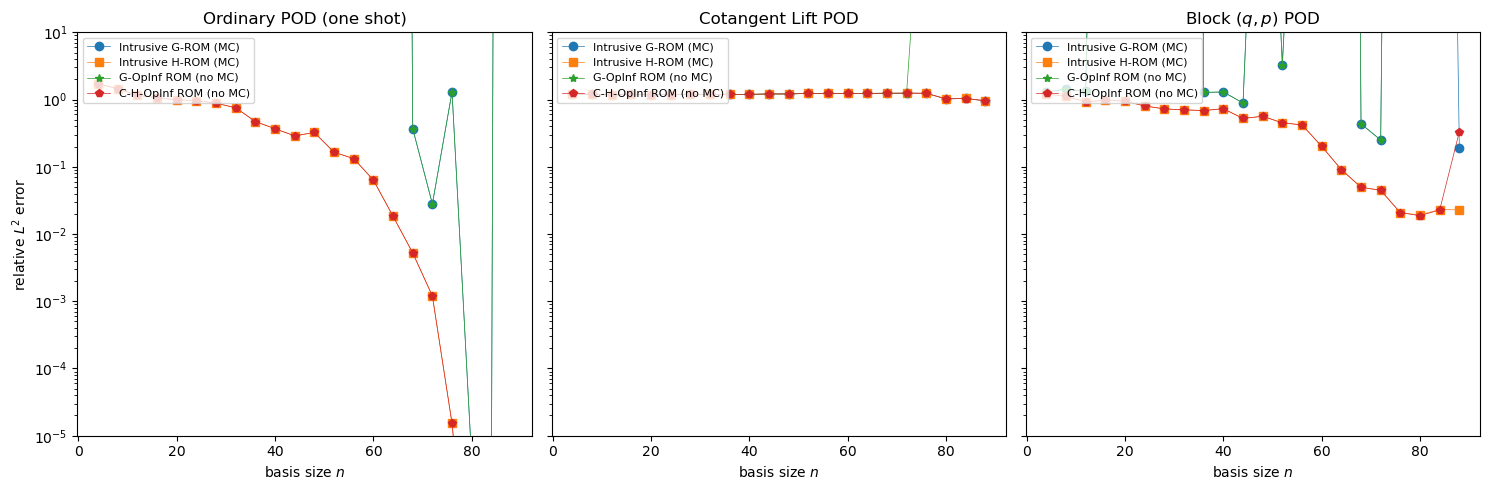

In [7]:
Asp = csc_matrix(A)

### Exact solution
Ttest     = 1e-1
NtTest    = 201
tTest     = np.linspace(0, Ttest, NtTest)
Xac       = ru.integrate_Linear_HFOM(tTest, data[0][:,0], J, A)[0]
exactE    = ru.compute_Hamiltonian(Xac, Asp)
N         = len(data[0][:,0])

### Parameters
rom_list = [PODmc, CLmc, QPmc]
nList = [4*(i+1) for i in range(22)]

eIntG  = np.zeros((3, len(nList)))
eIntH  = np.zeros((3, len(nList)))
eOpH   = np.zeros((3, len(nList)))
eOp    = np.zeros((3, len(nList)))
eOpA   = np.zeros((3, len(nList)))

HamileIntG = np.zeros((3, len(nList), NtTest))
HamileIntH = np.zeros((3, len(nList), NtTest))
HamileOpH  = np.zeros((3, len(nList), NtTest))
HamileOp   = np.zeros((3, len(nList), NtTest))
HamileOpA  = np.zeros((3, len(nList), NtTest))

XrecIntG = np.zeros((3, len(nList), N, NtTest))
XrecIntH = np.zeros((3, len(nList), N, NtTest))
XrecOp   = np.zeros((3, len(nList), N, NtTest))
XrecOpH  = np.zeros((3, len(nList), N, NtTest))
XrecOpA  = np.zeros((3, len(nList), N, NtTest))

fig, ax = plt.subplots(1, 3, figsize=(15,5), sharex=True, sharey=True)
ax[0].set_ylabel('relative $L^2$ error')

titleList   = ['Ordinary POD (one shot)', 
               'Cotangent Lift POD',
               'Block $(q,p)$ POD']
alpha=1

for i in range(len(rom_list)):

    rom = rom_list[i]

    rom.A = Asp

    for j,n in enumerate(nList):

        rom.assemble_Hamiltonian_ROM(n, J, A)
        try:
            rom.integrate_Hamiltonian_ROM(tTest, eps=0.0e-9, inconsistent=False) 
            XrecIntH[i,j] = rom.decode(rom.x_hat)
        except: pass
        rom.assemble_naive_ROM(n, J, A)
        try:
            rom.integrate_naive_ROM(tTest) 
            XrecIntG[i,j] = rom.decode(rom.x_hat)
        except: pass
        rom.infer_generic(n, Xt, Xdt, eps=0.0e-5, reproject=True)
        try: 
            rom.integrate_naive_ROM(tTest)
            XrecOp[i,j] = rom.decode(rom.x_hat)
        except: pass
        rom.infer_canonical_Hamiltonian(n, Xt, Xdt, J, eps=0.0e-5, old=False, reproject=True)
        try:
            rom.integrate_Hamiltonian_ROM(tTest, eps=0.0e-9, inconsistent=False)
            XrecOpA[i,j] = rom.decode(rom.x_hat)
        except: pass
        # rom.infer_noncanonical_Hamiltonian(n, Xdt, gHt, A)
        # try:
        #     rom.integrate_Hamiltonian_ROM(tTest, inconsistent=True)
        #     XrecOpH[i,j] = rom.decode(rom.x_hat)
        # except: pass
        # if i==1:
        #     opinf_rom.infer_SKZ_Hamiltonian(n, X1, Xt1, J)
        #     opinf_rom.integrate_Hamiltonian_ROM(tTest)
        #     XrecOpH[i,j] = opinf_rom.decode(opinf_rom.x_hat)
        # else:
        #     XrecOpH[i,j] = np.zeros_like(XrecIntG[i,j])

        eIntG[i,j] = ru.relError(Xac, XrecIntG[i,j])
        eIntH[i,j] = ru.relError(Xac, XrecIntH[i,j])
        eOp[i,j]   = ru.relError(Xac, XrecOp[i,j])
        # eOpH[i,j]  = ru.relError(Xac, XrecOpH[i,j])
        eOpA[i,j]  = ru.relError(Xac, XrecOpA[i,j])

        HamileIntG[i,j] = ru.compute_Hamiltonian(XrecIntG[i,j], Asp) - exactE
        HamileIntH[i,j] = ru.compute_Hamiltonian(XrecIntH[i,j], Asp) - exactE
        HamileOp[i,j]   = ru.compute_Hamiltonian(XrecOp[i,j], Asp) - exactE
        # HamileOpH[i,j]  = ru.compute_Hamiltonian(XrecOpH[i,j], Asp) - exactE
        HamileOpA[i,j]  = ru.compute_Hamiltonian(XrecOpA[i,j], Asp) - exactE

    # Print error magnitudes
    print(f'{i} the relative L2 errors for intrusive GROM are {eIntG[i]}')
    print(f'{i} the relative L2 errors for intrusive HROM are {eIntH[i]}')
    print(f'{i} the relative L2 errors for generic OpInf are {eOp[i]}')
    # print(f'{i} the relative L2 errors for noncanonical Hamiltonian OpInf are {eOpH[i]}')
    print(f'{i} the relative L2 errors for canonical Hamiltonian OpInf are {eOpA[i]}' + '\n')

    ax.flatten()[i].semilogy(nList, eIntG[i], label='Intrusive G-ROM (MC)', marker='o', linestyle='-', linewidth=0.5, markersize=6, alpha=alpha)
    ax.flatten()[i].semilogy(nList, eIntH[i], label='Intrusive H-ROM (MC)', marker='s', linestyle='-', linewidth=0.5, markersize=6, alpha=alpha)
    ax.flatten()[i].semilogy(nList, eOp[i],  label='G-OpInf ROM (no MC)', marker='*', linestyle='-', linewidth=0.5, markersize=6, alpha=alpha)
    # ax.flatten()[i].semilogy(nList, eOpH[i], label='NC-H-OpInf ROM (MC)', marker='v', linestyle='-', linewidth=0.5, markersize=6, alpha=alpha)
    ax.flatten()[i].semilogy(nList, eOpA[i], label='C-H-OpInf ROM (no MC)', marker='p', linestyle='-', linewidth=0.5, markersize=6, alpha=alpha)
    ax.flatten()[i].set_ylim([10**-5, 10.])
    ax.flatten()[i].set_title(f'{titleList[i]}')
    ax.flatten()[i].legend(prop={'size':8}, loc=2)
    ax.flatten()[i].set_xlabel('basis size $n$')

plt.tight_layout()
# plt.savefig(f'WavePlotT{Ttest}', transparent=True)
plt.show()

In [8]:
Xac.shape

(15828, 201)

the relative L2 errors for Lagrangian GROM are [0.3859419  0.39401146 0.31578724 0.27876879 0.27468696 0.12701067
 0.09689022 0.09033716 0.02911005 0.03438019 0.02798919 0.02261511
 0.02650159 0.03110867 0.02801566 0.0266329  0.02667678 0.02775335
 0.02713892 0.02684888 0.02684943 0.02582167]
the relative L2 errors for Lagrangian HROM are [0.04242806 0.03322705 0.02940159 0.02799848 0.02691077 0.02600085
 0.02559314 0.02537783 0.02531162 0.02529522 0.02527598 0.02527501
 0.02527544 0.02527569 0.02527581 0.02527588 0.02527594 0.02527599
 0.02527605 0.02527608 0.02527613 0.02527617]
the relative L2 errors for intrusive HROM are [2.92770794e+01 1.47365786e+00 1.47653262e-01 1.34414315e-01
 1.27026951e-01 1.20198191e-01 1.17191375e-01 1.03670605e-01
 3.34500297e-02 2.90195296e-02 2.79753323e-02 2.50577024e-02
 8.95793128e-03 8.18799552e-03 6.90594594e-03 1.46043319e-03
 3.76722097e-04 5.09875102e-05 9.90927782e-07 5.38466382e-10
 4.43073802e-10 4.09270545e-10]


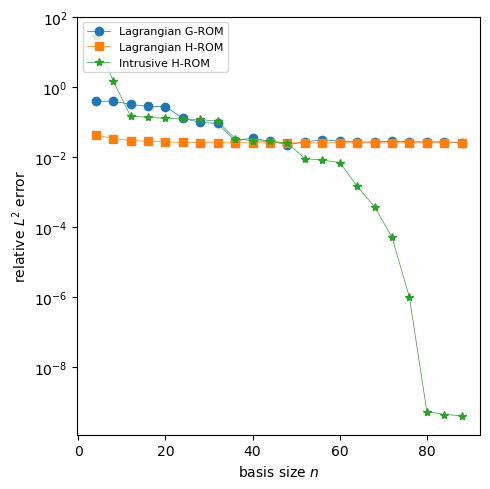

In [10]:
from scipy.sparse.linalg import inv

M    = csc_matrix(mmread(massName))
K    = csc_matrix(mmread(stiffName))

Qt   = Xt[:N//2]
Qdt  = Xdt[:N//2]
Qddt = inv(M) @ Xdt[-N//2:]

nList = [4*(i+1) for i in range(22)]

lag_rom = ru.Linear_Lagrangian_ROM(Qt)
lag_rom.set_reduced_basis('POD', centered=False)

QrecIntLag = np.zeros((len(nList), int(N//2), len(tTest)))
QrecIntHam = np.zeros((len(nList), int(N//2), len(tTest)))

eIntLag  = np.zeros(len(nList))
eIntHam  = np.zeros(len(nList))
eIntHam2 = np.zeros(len(nList))

for j,n in enumerate(nList):
    
    lag_rom.assemble_Lagrangian_ROM(n, M, K, Qdt, Qddt)
    try:
        lag_rom.integrate_Lagrangian_ROM(tTest)
        QrecIntLag[j] = lag_rom.decode(lag_rom.q_hat)
    except: pass
    eIntLag[j] = ru.relError(QrecIntLag[j], Xac[:N//2])
    lag_rom.assemble_Hamiltonian_from_Lagrangian_ROM(n, M, K, Qdt)
    # try:
    lag_rom.integrate_Hamiltonian_from_Lagrangian_ROM(tTest)
    QrecIntHam[j] = lag_rom.decode(lag_rom.q_hat)
    # except: pass
    eIntHam[j]  = ru.relError(QrecIntHam[j], Xac[:N//2])
    eIntHam2[j] = ru.relError(XrecIntH[0,j][:N//2], Xac[:N//2])


fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.set_ylabel('relative $L^2$ error')

# Print error magnitudes
print(f'the relative L2 errors for Lagrangian GROM are {eIntLag}')
print(f'the relative L2 errors for Lagrangian HROM are {eIntHam}')
print(f'the relative L2 errors for intrusive HROM are {eIntHam2}')

ax.semilogy(nList, eIntLag, label='Lagrangian G-ROM', marker='o', linestyle='-', linewidth=0.5, markersize=6, alpha=alpha)
ax.semilogy(nList, eIntHam, label='Lagrangian H-ROM', marker='s', linestyle='-', linewidth=0.5, markersize=6, alpha=alpha)
ax.semilogy(nList, eIntHam2, label='Intrusive H-ROM', marker='*', linestyle='-', linewidth=0.5, markersize=6, alpha=alpha)
# ax.set_ylim([10**-5, 10.])
# ax.set_title(f'{titleList[i]}')
ax.legend(prop={'size':8}, loc=2)
ax.set_xlabel('basis size $n$')

plt.tight_layout()
# plt.savefig(f'WavePlotT{Ttest}', transparent=True)
plt.show()

## Computing the FOM solution in Hamiltonian form and building POD basis

This preserved energy way better than Irina's data.  Not sure why.... See plots.

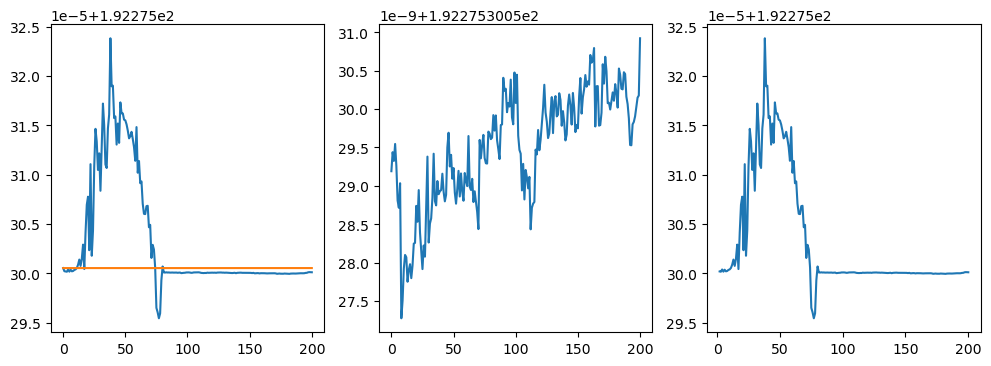

In [22]:
# # Get data from exodus file (400 snaps)
data, J, A     = assemble_FOM(exo_copy)
Asp            = csc_matrix(A)
Jsp            = csc_matrix(J)

# nInvIDmap2 = np.concatenate((nInvIDmap,nInvIDmap))
nIDmap2 = np.concatenate((nIDmap,nIDmap))

# # Doing the integration (takes about 2:40)
tTrain = np.linspace(0, 0.02, 201)
Xt, Xdt, gHt = ru.integrate_Linear_HFOM(tTrain, data[0][:,0], Jsp, Asp)

# Saving the data
dicto = {'x': Xt, 'xDot': Xdt, 'gradH': gHt}
from scipy.io import savemat
savemat('bracket/bracket_snaps2.mat', dicto)

# Ignore exodus file and get data from Hamiltonian system (10001 snaps)
mat            = loadmat('bracket/bracket_snaps2.mat')
xData          = mat['x']
xDotData       = mat['xDot']
gradHData      = mat['gradH']

# xData, xDotData, gradHData = data

# Computing top 200 singular vectors
UU, SS, VVt = randomized_svd(xData, n_components=200, random_state=0)

Nover2 = len(xData)//2
Xo = np.concatenate((xData[:Nover2], xData[Nover2:]), axis=1)
UUo, SSo = randomized_svd(Xo, n_components=200, random_state=0)[:2]

UUq = randomized_svd(xData[:Nover2], n_components=200, random_state=0)[0]
UUp = randomized_svd(xData[Nover2:], n_components=200, random_state=0)[0]

# Plotting Hamiltonian 
hamIrina   = Hamil(data[0], Asp)
hamAnthony = Hamil(xData, Asp)
idxList    = np.array([i for i in range(201)])

fig, ax = plt.subplots(1, 3, figsize=(12,4))
ax[2].plot(idxList[2:], hamIrina[2:])
ax[1].plot(idxList, hamAnthony)
ax[0].plot(idxList, hamIrina)
ax[0].plot(idxList, hamAnthony)
plt.show()

0.00812245853416218 0.1389590183458417 False
(15828, 200)
201 201


0.00812245853416218

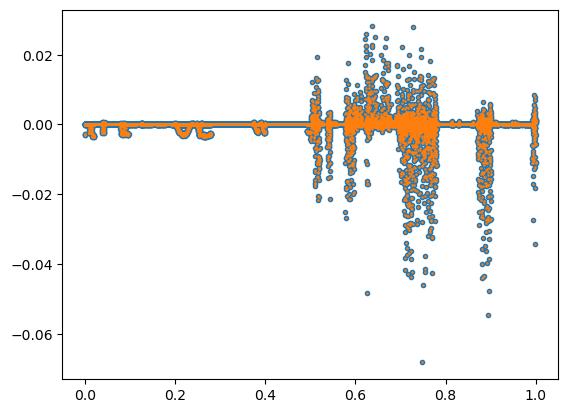

In [38]:
print(np.max(np.abs(data[0][:N])), np.max(np.abs(data[0][N:])), np.allclose(xData,data[0]))

print(UU.shape)
smth = np.linspace(0,1,len(xData))

plt.scatter(smth, xData[:,140], marker='.')
plt.scatter(smth, data[0][:,140], s=0.7)

print(data[0].shape[1], xData.shape[1])

np.allclose(data[0],xData)

np.amax(np.abs(data[0][:N]))

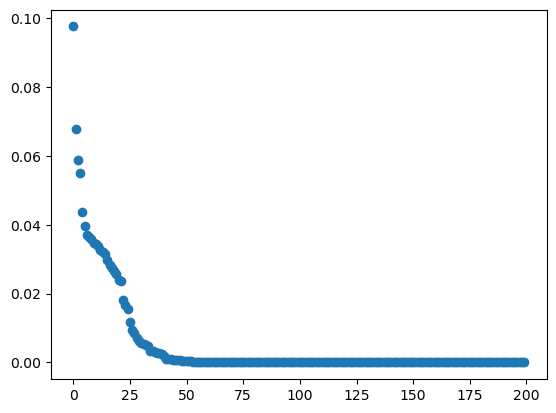

[7.05487466e-01 5.89511059e-01 4.79485663e-01 3.64892957e-01
 2.48869335e-01 1.39504142e-01 7.97357910e-02 5.21229249e-02
 3.11279249e-02 1.53894586e-02 9.35683068e-03 5.29428347e-03
 2.98998122e-03 1.55945535e-03 6.97465919e-04 2.64120849e-04
 7.11479101e-05 2.17554983e-05 2.91569308e-07 6.97180101e-10
 2.83487358e-10 1.40753523e-10 8.26002093e-11 5.09735792e-11]


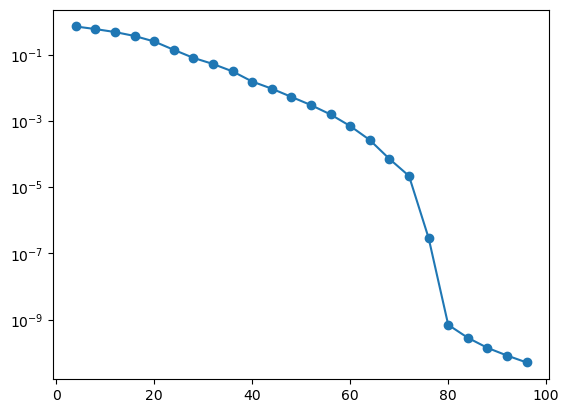

In [13]:
# N = exo_copy.num_nodes()

# disp_xRecInt  = xData[::3][:N,:]
# disp_yRecInt  = xData[1::3][:N,:]
# disp_zRecInt  = xData[2::3][:N,:]

# for i in range(exo_copy.num_times()):
#     exo_copy.put_node_variable_values("disp_IntRom_x", i+1, disp_xRecInt[:,i])
#     exo_copy.put_node_variable_values("disp_IntRom_y", i+1, disp_yRecInt[:,i])
#     exo_copy.put_node_variable_values("disp_IntRom_z", i+1, disp_zRecInt[:,i])    

# UU, Sigma, VVt = randomized_svd(xData, n_components=200, random_state=0)
# UU, Sigma, VVt = svd(xData)
# dicto = {'U': UU, 'Sigma': Sigma, 'Vt': VVt}
# from scipy.io import savemat
# savemat('bracket/svd.mat', dicto)

plt.scatter([i for i in range(200)], Sigma[:200]/np.sum(Sigma))
plt.show()

# Parameters for training
NtTest = 401 #qData.shape[1]
nList = [4*i for i in range(1,25)]
errU  = np.zeros(len(nList))

for j, n in enumerate(nList):
    U         = UU[:,:n]
    reconU    = U @ U.T @ xData
    errU[j]    = u.relError(xData, reconU)

print(errU)
plt.semilogy(nList, errU, marker='o')

# markers = ['.','o','1','^','s']

# # Full plot
# f, axes = plt.subplots(1, 3, figsize=(15,5))
# ax = axes.flatten()
# for i in range(5):
#     ax[0].loglog(nList, errU[i][0], label=labels[i], marker=markers[i])
#     ax[1].loglog(nList, errUq[i][0], label=labels[i], marker=markers[i])
#     ax[2].loglog(nList, errUaug[i][0], label=labels[i], marker=markers[i])
# ax[0].set_title('Projection Errors both q and p (Full)')
# ax[1].set_title('Projection Errors q only (Full)')
# ax[2].set_title('Projection Errors augmented (Full)')
# ax[0].legend(labels=labels, loc=3)
# ax[1].legend(labels=labels, loc=3)
# ax[2].legend(labels=labels, loc=3)
# plt.show()

## Computing the ROMs

Here I compute all of the relevant ROM solutions and plot the errors

the relative L2 errors for intrusive G-ROM are [1.11102544 1.15210977 1.1607924  1.19066592 1.22476754 1.29649806
 1.30681404 1.30902634 1.31200006 1.30570707 1.30422597 1.3040684
 1.31575494 1.32934189 1.32474906]
the relative L2 errors for intrusive H-ROM are [1.11102544 1.15210977 1.1607924  1.19066592 1.22476754 1.29649806
 1.30681404 1.30902634 1.31200006 1.30570707 1.30422597 1.3040684
 1.31575494 1.32934189 1.32474906]
the relative L2 errors for noncanonical Hamiltonian OpInf are [1.11102544 1.15210977 1.1607924  1.19066592 1.22476754 1.29649806
 1.30681404 1.30902634 1.31200002 1.30570707 1.30422595 1.30406842
 1.31574889 1.32943743 1.32445761]
the relative L2 errors for generic OpInf are [2.62151725e+00 1.58831417e+00 1.05889039e+00 1.14827542e+00
 1.17017513e+00 1.29468133e+05            inf 4.91685724e+43
 1.60330047e+00 5.19446717e+59 1.42801661e+00 5.99573867e+45
 7.34633477e+10 5.83095200e+13 1.32305394e+86]
the relative L2 errors for canonical Hamiltonian OpInf are [3.86

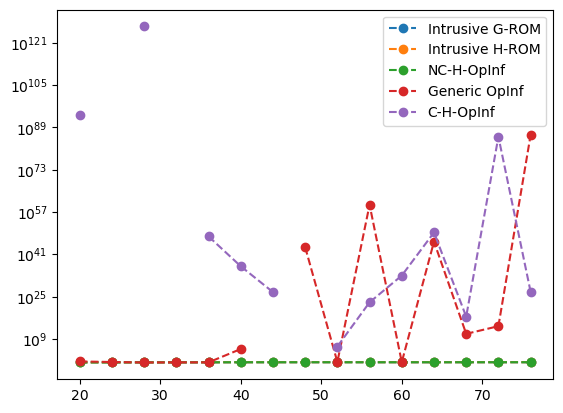

In [31]:
NtTest = 201 #qData.shape[1]
T = 0.02
tTest = np.linspace(0, T, NtTest)

ic = xData[:,0]
# Xtest = np.concatenate((X, X[:,1:]), axis=1)
Xtest = xData
# Xtest = ru.integrate_Linear_HFOM(tTest, xData[:,0], Jsp, Asp)[0]

Umat = [UUo, UUo]
# Umat = [UUq,UUp]
# Umat = UU

# nList = [5, 10, 28, 45, 60]
nList = [4*i for i in range(5,20)]
eIntG  = np.zeros(len(nList))
eIntH  = np.zeros(len(nList))
eOpH  = np.zeros(len(nList))
eOp   = np.zeros(len(nList))
eOpA  = np.zeros(len(nList))

OpInfLists = ou.build_OpInf_stuff(Umat, xData, xDotData, gradHData, Jsp, nList[-1])
OpLists    = ru.build_Linear_ROM_Ops(Umat, Jsp, Asp, ic, nList[-1], MC=False)
OpListOL   = list(OpLists[0])

# Compute once and for all
# LhatOpHFull = ou.HOpInf_for_L(OpInfLists[0], nList[-1], eps=1.0e-15)
# DhatOpFull  = ou.generic_OpInf(OpInfLists[2], nList[-1], SS, eps=1.0e-15)
# AhatOpFull  = ou.HOpInf_for_gradH(OpInfLists[1], nList[-1], SS, eps=1.0e-15)

for i,n in enumerate(nList):
    # LhatOpH = LhatOpHFull[:n,:n]
    # DhatOp  = DhatOpFull[:n,:n]
    # AhatOp  = AhatOpFull[:n,:n]

    LhatOpH = ou.NC_H_OpInf(OpInfLists[0], n, eps=1.0e-10)
    DhatOp  = ou.G_OpInf(OpInfLists[2], n, eps=1.0e-1)
    AhatOp  = ou.C_H_OpInf(OpInfLists[1], n, eps=1.0e-5)

    OpListOL[0] = LhatOpH

    XrecIntG = ru.integrate_Linear_ROM(tTest, OpLists[1], ic, Umat, n, MC=False, Hamiltonian=False)
    XrecIntH = ru.integrate_Linear_ROM(tTest, OpLists[0], ic, Umat, n, MC=False, Hamiltonian=True)
    XrecOpH = ru.integrate_Linear_ROM(tTest, OpListOL, ic, Umat, n, MC=False, Hamiltonian=True)
    XrecOp  = ru.integrate_OpInf_ROM(tTest, DhatOp, ic, Umat)
    XrecOpA = ru.integrate_OpInf_ROM(tTest, AhatOp, ic, Umat, Jsp)
    eIntG[i] = ru.relError(Xtest, XrecIntG)
    eIntH[i] = ru.relError(Xtest, XrecIntH)
    eOpH[i] = ru.relError(Xtest, XrecOpH)
    eOp[i]  = ru.relError(Xtest, XrecOp)
    eOpA[i] = ru.relError(Xtest, XrecOpA)

# Print error magnitudes
print(f'the relative L2 errors for intrusive G-ROM are {eIntG}')
print(f'the relative L2 errors for intrusive H-ROM are {eIntH}')
print(f'the relative L2 errors for noncanonical Hamiltonian OpInf are {eOpH}')
print(f'the relative L2 errors for generic OpInf are {eOp}')
print(f'the relative L2 errors for canonical Hamiltonian OpInf are {eOpA}')

plt.semilogy(nList, eIntG, label='Intrusive G-ROM', marker='o', linestyle='--')
plt.semilogy(nList, eIntH, label='Intrusive H-ROM', marker='o', linestyle='--')
plt.semilogy(nList, eOpH, label='NC-H-OpInf', marker='o', linestyle='--')
plt.semilogy(nList, eOp,  label='Generic OpInf', marker='o', linestyle='--')
plt.semilogy(nList, eOpA,  label='C-H-OpInf', marker='o', linestyle='--')
# plt.ylim([10**-8,10**2.])
plt.legend()



In [25]:
import importlib
importlib.reload(ou)

<module 'OpInf_utils' from '/Users/adgrube/Desktop/Code/hamOL/exodus-python-scripts/../OpInf_utils.py'>

the relative L2 errors for intrusive ROM are [1.39952615]
the relative L2 errors for noncanonical Hamiltonian OpInf are [1.00112936]
the relative L2 errors for generic OpInf are [2.49554979e-06]
the relative L2 errors for canonical Hamiltonian OpInf are [1.46350478]


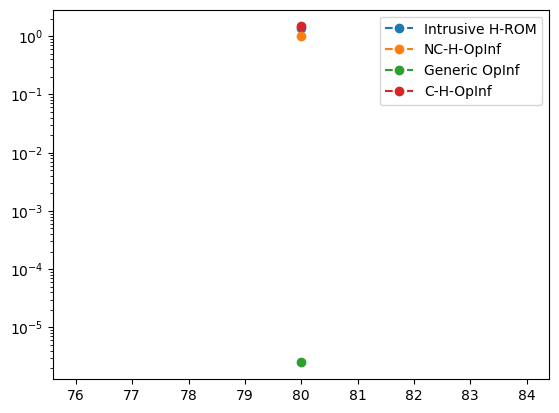

In [18]:
NtTest = 201 #qData.shape[1]
T = 0.02
tTest = np.linspace(0, T, NtTest)

tList = [i for i in range(401) if i != 1]

ic = xData[:,0].reshape(-1,1)
# Xtest = np.concatenate((X, X[:,1:]), axis=1)
Xtest = xData
# Xtest = u.integrate_Linear_HFOM(tTest, xData[:,0], Jsp, Asp)[0]

# nList = [5, 10, 28, 45, 60]
nList = [4*i for i in range(21,23)]
nList = [4*20]
eInt  = np.zeros(len(nList))
eOpH  = np.zeros(len(nList))
eOp   = np.zeros(len(nList))
eOpA  = np.zeros(len(nList))

# Compute once and for all
LhatOpHFull = u.HOpInf_for_L(xDotData, gradHData, UU, nList[-1])
DhatOpFull  = u.generic_OpInf(xData, xDotData, UU, nList[-1])
AhatOpFull  = u.HOpInf_for_gradH(xData, xDotData, Jsp, UU, nList[-1])

for i,n in enumerate(nList):
    LhatOpH = LhatOpHFull[:n,:n]
    DhatOp  = DhatOpFull[:n,:n]
    AhatOp  = AhatOpFull[:n,:n]
    # XrecInt = u.integrate_Linear_HROM(tTest, Jsp, Asp, ic, UU, n, MC=False)
    XrecInt = u.integrate_Linear_HROM(tTest, Jsp, Asp, ic, UU, n, MC=False)
    XrecOpH = u.integrate_Linear_HROM(tTest, LhatOpH, Asp, ic, UU, n, MC=False)
    XrecOp  = u.integrate_OpInf_ROM(tTest, ic, DhatOp, UU)
    XrecOpA = u.integrate_OpInf_ROM(tTest, ic, AhatOp, UU, Jsp)
    eInt[i] = u.relError(Xtest, XrecInt)
    eOpH[i] = u.relError(Xtest, XrecOpH)
    eOp[i]  = u.relError(Xtest, XrecOp)
    eOpA[i] = u.relError(Xtest, XrecOpA)

# Print error magnitudes
print(f'the relative L2 errors for intrusive ROM are {eInt}')
print(f'the relative L2 errors for noncanonical Hamiltonian OpInf are {eOpH}')
print(f'the relative L2 errors for generic OpInf are {eOp}')
print(f'the relative L2 errors for canonical Hamiltonian OpInf are {eOpA}')

plt.semilogy(nList, eInt, label='Intrusive H-ROM', marker='o', linestyle='--')
plt.semilogy(nList, eOpH, label='NC-H-OpInf', marker='o', linestyle='--')
plt.semilogy(nList, eOp,  label='Generic OpInf', marker='o', linestyle='--')
plt.semilogy(nList, eOpA,  label='C-H-OpInf', marker='o', linestyle='--')
# plt.ylim([10**-6,10**-2.])
plt.legend()

## Writing results to exodus file

There's probably a cleaner way to do this...

In [25]:
N = exo_copy.num_nodes()

disp_xTest  = Xtest[::3][:N,:]
disp_yTest  = Xtest[1::3][:N,:]
disp_zTest  = Xtest[2::3][:N,:]

disp_xRecInt = XrecInt[::3][:N,:]
disp_yRecInt = XrecInt[1::3][:N,:]
disp_zRecInt = XrecInt[2::3][:N,:]

disp_xRecOpH = XrecOpH[::3][:N,:]
disp_yRecOpH = XrecOpH[1::3][:N,:]
disp_zRecOpH = XrecOpH[2::3][:N,:]

disp_xRecOpA = XrecOpA[::3][:N,:]
disp_yRecOpA = XrecOpA[1::3][:N,:]
disp_zRecOpA = XrecOpA[2::3][:N,:]

disp_xRecOp  = XrecOp[::3][:N,:]
disp_yRecOp  = XrecOp[1::3][:N,:]
disp_zRecOp  = XrecOp[2::3][:N,:]

for i in range(exo_copy.num_times()):
    exo_copy.put_node_variable_values("disp_IntRom_x", i+1, disp_xRecInt[:,i])
    exo_copy.put_node_variable_values("disp_IntRom_y", i+1, disp_yRecInt[:,i])
    exo_copy.put_node_variable_values("disp_IntRom_z", i+1, disp_zRecInt[:,i])

    exo_copy.put_node_variable_values("disp_NC-H-OpRom_x", i+1, disp_xRecOpH[:,i])
    exo_copy.put_node_variable_values("disp_NC-H-OpRom_y", i+1, disp_yRecOpH[:,i])
    exo_copy.put_node_variable_values("disp_NC-H-OpRom_z", i+1, disp_zRecOpH[:,i])

    exo_copy.put_node_variable_values("disp_C-H-OpRom_x", i+1, disp_xRecOpA[:,i])
    exo_copy.put_node_variable_values("disp_C-H-OpRom_y", i+1, disp_yRecOpA[:,i])
    exo_copy.put_node_variable_values("disp_C-H-OpRom_z", i+1, disp_zRecOpA[:,i])

    exo_copy.put_node_variable_values("disp_OpRom_x", i+1, disp_xRecOp[:,i])
    exo_copy.put_node_variable_values("disp_OpRom_y", i+1, disp_yRecOp[:,i])
    exo_copy.put_node_variable_values("disp_OpRom_z", i+1, disp_zRecOp[:,i])

## Making movie of results

/var/folders/fm/5nmtz1sx0qgfhs9hqsd70ycc00434g/T/ipykernel_26529/2627719420.py:28: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread("./png/comp-{:03d}.png".format(frame))


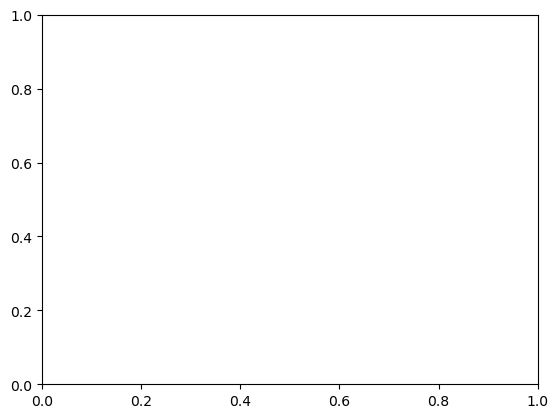

In [96]:
import imageio
import os
from IPython import display
def make_movie(N, xRange, Xtest, XrecInt, XrecOpH, 
               XrecOpA, XrecOp, xLims, yLims, frameskip=1, save=False):

    fig, ax = plt.subplots(1,1)
    for frame in range(Xtest.shape[1])[::frameskip]:
        ax.set_xlim(xLims)
        ax.set_ylim(yLims)
        ax.scatter(xRange, Xtest[:N, frame], s=4, label='FOM Solution')
        ax.scatter(xRange, XrecInt[:N, frame], s=2, label='Intrusive H-ROM')
        ax.scatter(xRange, XrecOpH[:N, frame], s=1, label='OpInf NC H-ROM')
        ax.scatter(xRange, XrecOpA[:N, frame], s=0.5, label='OpInf C H-ROM')
        ax.scatter(xRange, XrecOp[:N, frame], s=0.25,
                color='gray', label='OpInf ROM')
        plt.legend()
        if save:
            plt.savefig("./png/comp-{:03d}.png".format(frame))
        display.display(plt.gcf())
        display.clear_output(wait=True)
        plt.cla()

    if save:
        # build gif
        with imageio.get_writer('mygif.gif', mode='I') as writer:
            for frame in range(Xtest.shape[1])[::frameskip]:
                image = imageio.imread("./png/comp-{:03d}.png".format(frame))
                writer.append_data(image)

        # Remove files
        for frame in range(Xtest.shape[1])[::frameskip]:
            os.remove('./png/comp-{:03d}.png'.format(frame))


zTest = Xtest[2::3][:4004]
zRecInt = XrecInt[2::3][:4004]
zRecOpH = XrecOpH[2::3][:4004]
zRecOpA = XrecOpA[2::3][:4004]
zRecOp  = XrecInt[2::3][:4004]

make_movie(4004, z, zTest, zRecInt, zRecOpH, zRecOpA,
               zRecOp, [-0.05,1.05], [-0.0011,0.0011], frameskip=100, save=True)

In [30]:
exo_copy.close()

Closing exodus file: bracket/bracket_velIC_100_copy.e
